## Crypto Analysis

Majority of the code is a copy-paste from [_Analyzing Cryptocurrency Markets Using Python_](https://blog.patricktriest.com/analyzing-cryptocurrencies-python/)

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [3]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    cache_path = 'pickle/' + cache_path
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [4]:
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')


Cached BCHARTS/KRAKENUSD at pickle/BCHARTS-KRAKENUSD.pkl


In [5]:
btc_usd_price_kraken.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [6]:
btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
py.iplot([btc_trace])

In [7]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Cached BCHARTS/COINBASEUSD at pickle/BCHARTS-COINBASEUSD.pkl
Cached BCHARTS/BITSTAMPUSD at pickle/BCHARTS-BITSTAMPUSD.pkl
Cached BCHARTS/ITBITUSD at pickle/BCHARTS-ITBITUSD.pkl


In [8]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [9]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [10]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

In [26]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    
    '''Download and cache JSON data, return as a dataframe.'''
    cache_path = 'pickle/{}.pkl'.format(poloniex_pair)
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    
    df = df.set_index('date')
    return df

In [27]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420092000.0&end=1535920768.679329&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420092000.0&end=1535920768.679329&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420092000.0&end=1535920768.679329&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420092000.0&end=1535920768.679329&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420092000.0&end=1535920768.679329&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420092000.0&end=1535920768.679329&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420092000.0&end=1535920768.679329&period=86

In [29]:
# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']
    
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

In [30]:
df_ETC_LTC = combined_df.loc[combined_df.index>='2018-05-01',['ETC','LTC']]

In [31]:
df_ETC = combined_df.loc[combined_df.index>='2018-05-01',['ETC']]
df_ETC.to_pickle('pickle/ETC_prices.pkl')

## My Study: Cointegration of ETH and LTC

In [17]:
reg = sm.ols(formula="ETC ~ LTC", data=df_ETC_LTC).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ETC   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     132.9
Date:                Sun, 02 Sep 2018   Prob (F-statistic):           2.97e-21
Time:                        15:02:14   Log-Likelihood:                -245.69
No. Observations:                 124   AIC:                             495.4
Df Residuals:                     122   BIC:                             501.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4317      0.513     20.319      0.000       9.415      11.448
LTC            0.0588      0.005     11.529      0.000       0.049       0.069
==============================================================================
Omnibus:                        8.746   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                4.000
Skew:                           0.170   Prob(JB):                        0.135
Kurtosis:                       2.189   Cond. No.                         325.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
df_ETC_LTC.corr()

,ETC,LTC
ETC,1.000000,0.722097
LTC,0.722097,1.000000


In [25]:
reg.predict([65.65])

PatsyError: Error evaluating factor: TypeError: list indices must be integers or slices, not str
    ETC ~ LTC
          ^^^

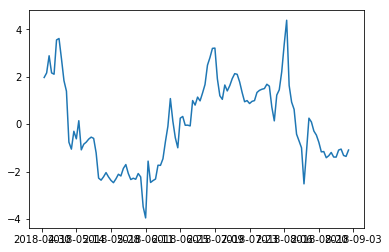

In [18]:
plt.plot(reg.resid.index,reg.resid)



In [36]:
adfuller(reg.resid)

(-1.1771534401248314,
 0.6833457141043313,
 4,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 726.7633826517582)